<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

ЦЕЛЬ:
- Спрогнозировать количество заказов такси на следующий час

ЗАДАЧА:
- Построить модель для такого предсказания

ХОД РАБОТЫ:

1) подготовка данных

2) анализ

3) обучение

4) тестирование

5) общий вывод

ОПИСАНИЕ ДАННЫХ

Данные лежат в файле /datasets/taxi.csv. Количество заказов находится в столбце 'num_orders' (от англ. number of orders, «число заказов»).

In [1]:
!pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install --upgrade scikit-learn==1.2 -q

In [3]:
!pip install phik -q

In [4]:
import time
import lightgbm as lgb

from phik import phik_matrix
from phik.report import plot_correlation_matrix
from statsmodels.tsa.seasonal import seasonal_decompose

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.model_selection import TimeSeriesSplit

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

## Подготовка

In [5]:
# data = pd.read_csv('/datasets/taxi.csv')
data = pd.read_csv('C:/Users/admin/Downloads/taxi.csv')

In [6]:
def check_data(name):
    print('общая информация ***************************************************************************************************')
    name.info()
    print('первые 5 строк *****************************************************************************************************')
    display(name.head())
    print('название столбцов **************************************************************************************************')
    display(name.columns)
    print('количество пропусков ***********************************************************************************************')
    print(name.isnull().sum())
    print('количество явных дубликатов ********************************************************************************************')
    print(name.duplicated().sum())
    display(name.describe().T)

In [7]:
check_data(data)

общая информация ***************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB
первые 5 строк *****************************************************************************************************


datetime  num_orders
0  2018-03-01 00:00:00           9
1  2018-03-01 00:10:00          14
2  2018-03-01 00:20:00          28
3  2018-03-01 00:30:00          20
4  2018-03-01 00:40:00          32

название столбцов **************************************************************************************************


Index(['datetime', 'num_orders'], dtype='object')

количество пропусков ***********************************************************************************************
datetime      0
num_orders    0
dtype: int64
количество явных дубликатов ********************************************************************************************
0


count       mean      std  min  25%   50%   75%    max
num_orders  26496.0  14.070463  9.21133  0.0  8.0  13.0  19.0  119.0

Изменим тип данных Datetime с object на datetime64

In [8]:
# Преобразуем столбец с датами в datetime64
data['datetime'] = pd.to_datetime(data['datetime'])  # замените 'date_column' на фактическое имя столбца

# Проверяем информацию о данных снова
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB
None


Чтобы работать с временными рядами, необходимо проверить, в хронологическом ли порядке расположены даты и время. Для этого нужно посмотреть атрибут индекса таблицы is_monotonic. Если порядок соблюдён, атрибут вернёт True, если нет — False:

Установим индекс таблицы равным столбцу Datetime.

In [9]:
data.set_index(data.columns[0], inplace=True) 

Выполним ресемплирование по часу. Выберем интервал в один час, по каждому — вычислите суммарное количество заказов.

In [10]:
data = data.resample('1H').sum()

In [11]:
if data.index.is_monotonic_increasing:
    print("Индекс монотонно возрастающий.")
else:
    print("Индекс не монотонно возрастающий.")

Индекс монотонно возрастающий.


Вывод 1:
- Пропусков в датасете нет, дубликатов тоже, значения признаков соответствуют заданным типам => данные в норме, можно приступать к анализу данных)

ВАЖНО отметить что период в этой таблице до ресемплирования равен 10 минутам, а после 1 час

- datetime (англ. «дата-время») — значение даты и времени на временной оси. Переменная называется так же, как и тип данных datetime.

-  Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

Преобразован столбец datatime в тип datatime64, изменена инденксация)

## Анализ

Построим график временного ряда за все время которое есть в таблице

In [12]:
def time_series_graph(DATA, TITLE):
    plt.figure(figsize=(15, 7))
    plt.plot(DATA)
    plt.title(TITLE)
    plt.grid(True)
    plt.show();

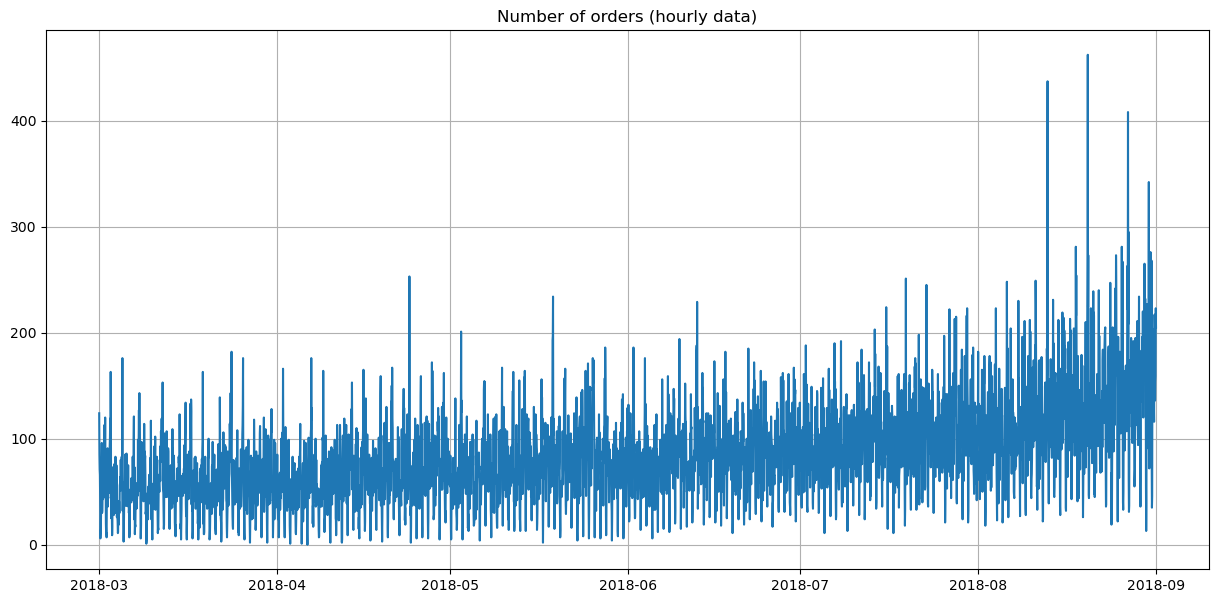

In [13]:
time_series_graph(data, 'Number of orders (hourly data)')

Ничего не понятно, понятно только то, что график не стационарный, меняется среднее значение, а именно увеличивается. То есть за прошедшие месяцы количество заказов увеличилось.

Построим график временного ряда за первую и последнюю недели

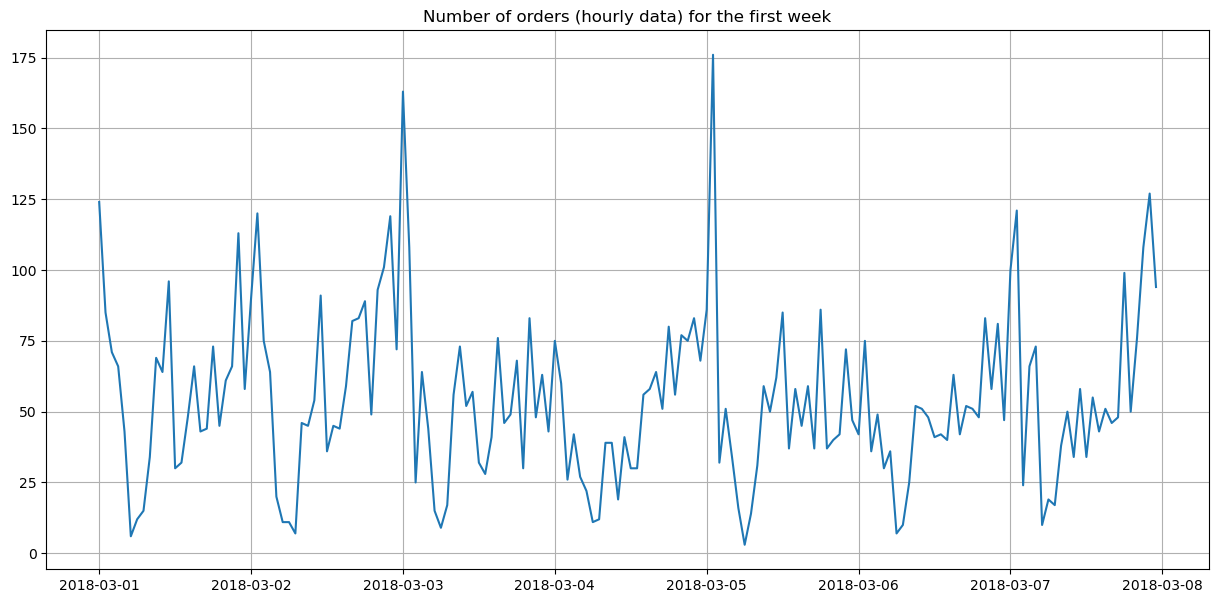

In [14]:
time_series_graph(data['2018-03-01':'2018-03-07'], 'Number of orders (hourly data) for the first week')

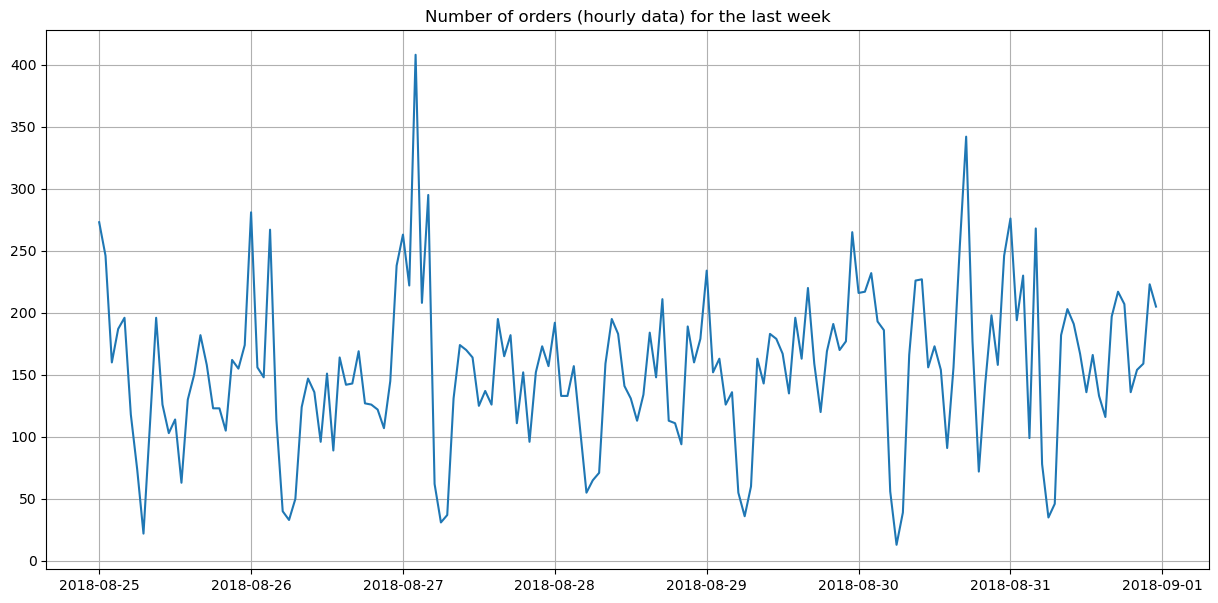

In [15]:
time_series_graph(data['2018-08-25':'2018-08-31'], 'Number of orders (hourly data) for the last week')

Проанализируем рандомные два дня за первую и последнюю недели

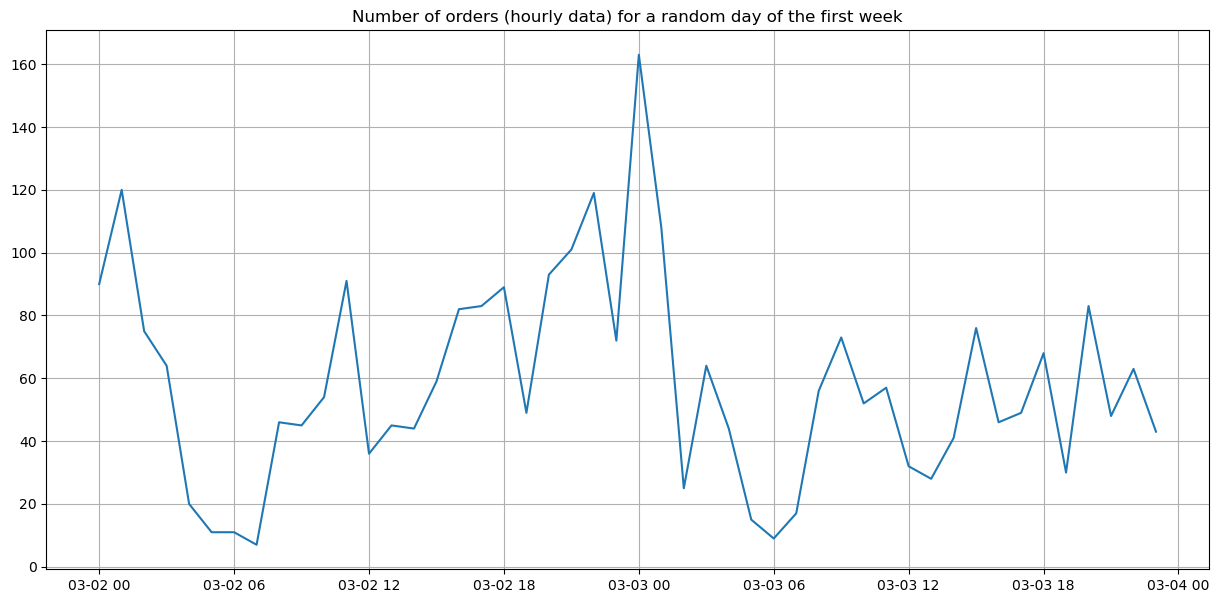

In [16]:
time_series_graph(data['2018-03-02':'2018-03-03'], 'Number of orders (hourly data) for a random day of the first week')

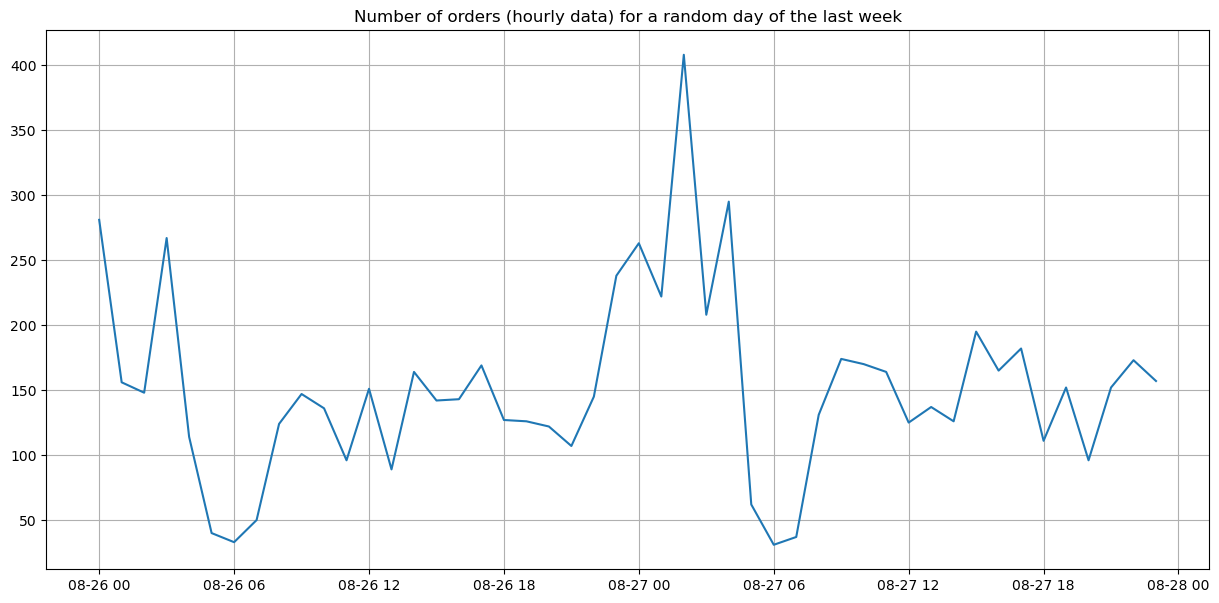

In [17]:
time_series_graph(data['2018-08-26':'2018-08-27'], 'Number of orders (hourly data) for a random day of the last week')

Невооруженным глазом видно, что количество заказов за 6 месяцев увеличилось почти вдвое, также у обоих графиков наблюдается  рост количества заказов днем, а наибольшее количество заказов наблюдается ближе к ночи (в интервале  12 ночи - 2 часа ночи), далее наблюдается спад в ночное время суток и примерно к 6 утра наблюдается минимальное количество заказов. То есть максимальное количество заказов достигается в определенные ночные часы, а минимальное количество заказов наблюдается ранним утром.

Изучим трендовую, сезонную и шумовую состовляющие данных и построим соответствующие графики

In [18]:
decomposed = seasonal_decompose(data) 

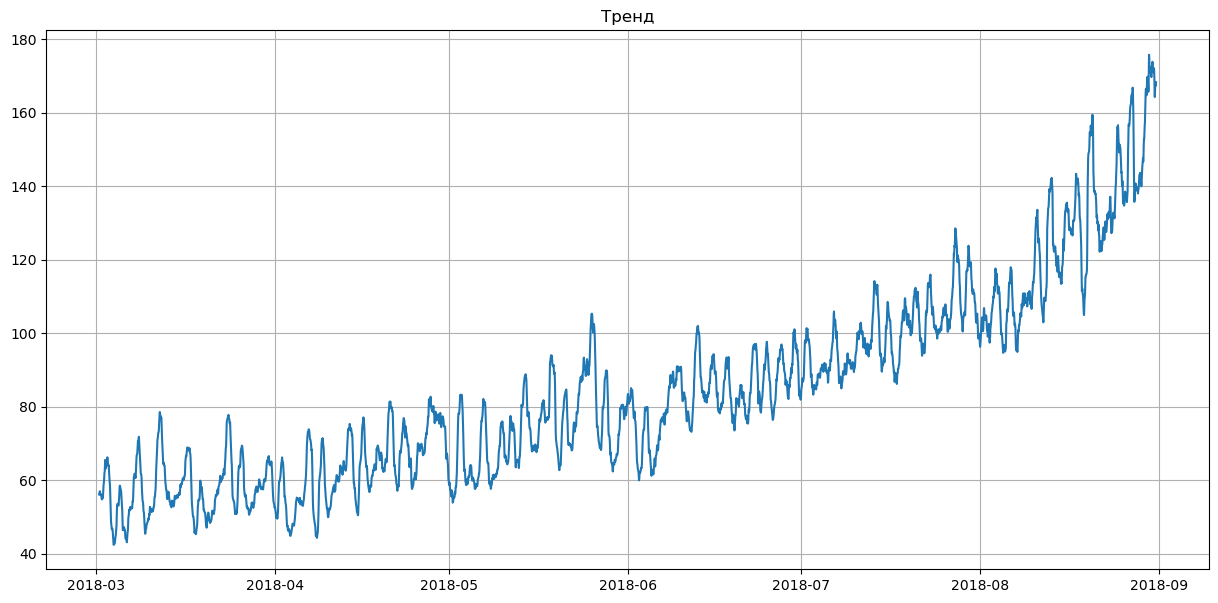

In [19]:
time_series_graph(decomposed.trend, 'Тренд')

Построим график со скользящим средним, такой параметр, как размер окна, воьзмем 168)

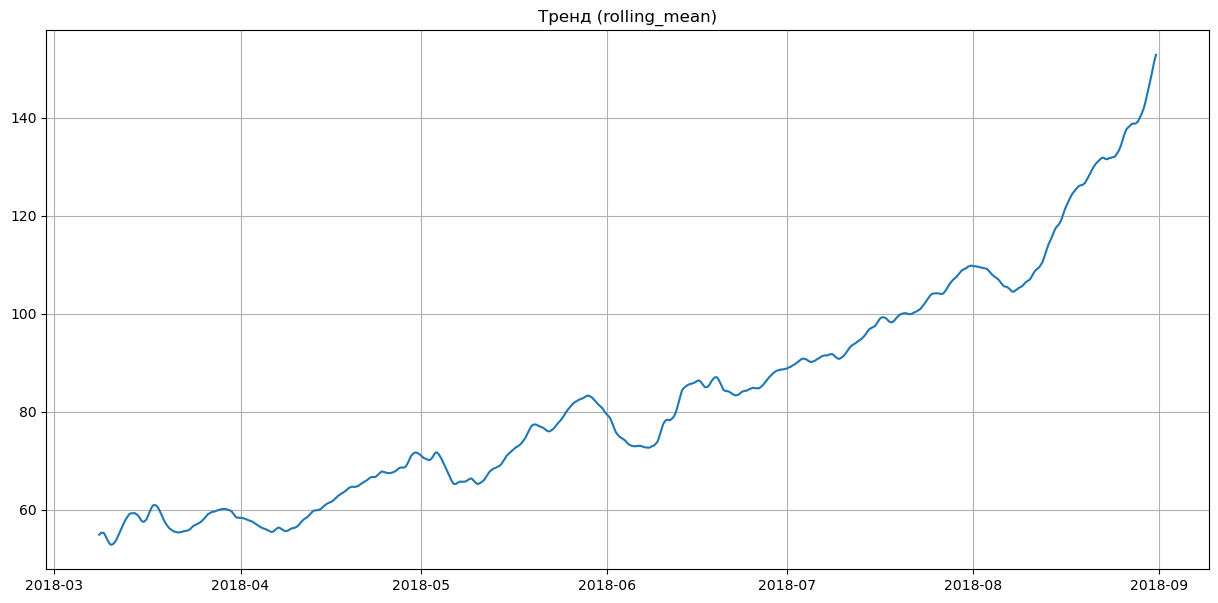

In [20]:
time_series_graph(decomposed.trend.rolling(168).mean(), 'Тренд (rolling_mean)')

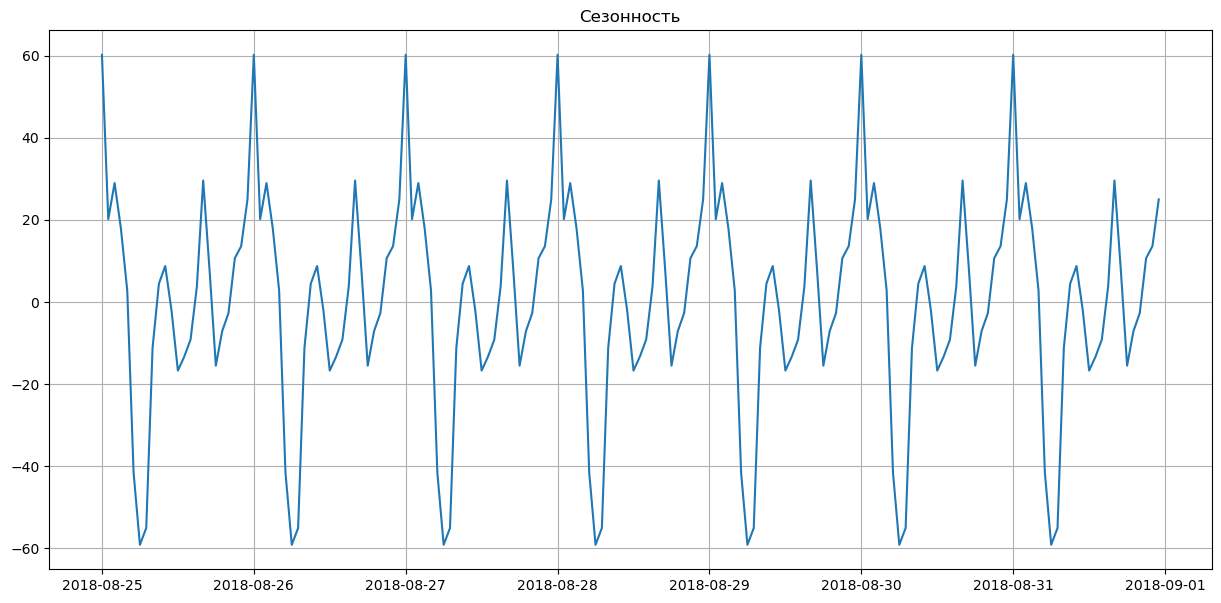

In [21]:
time_series_graph(decomposed.seasonal.tail(168), 'Сезонность' )

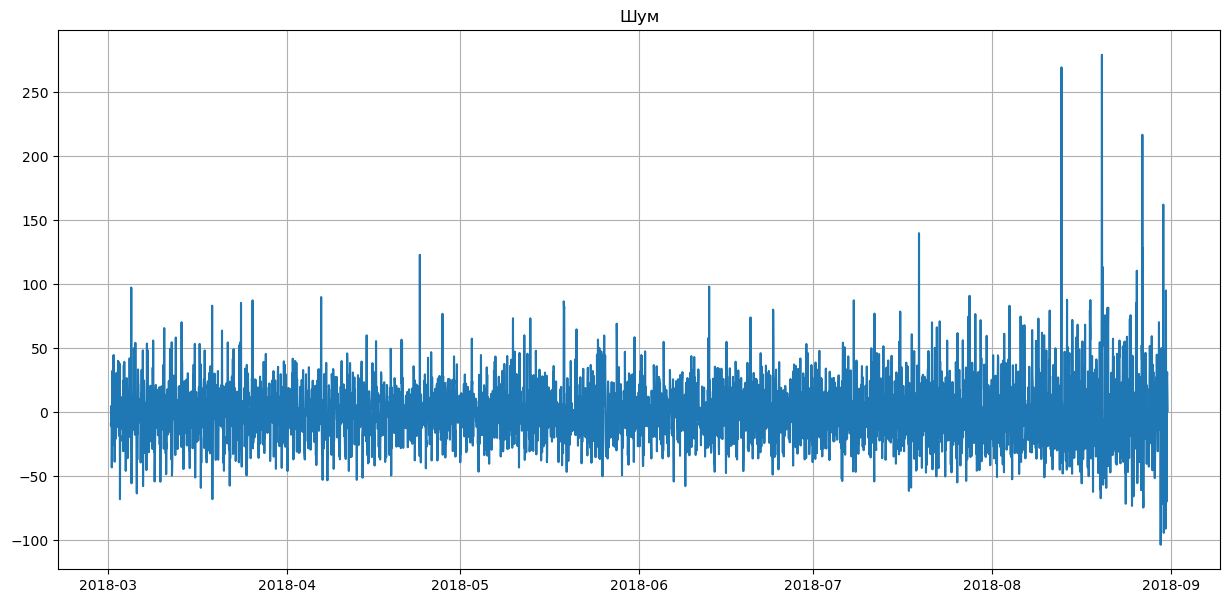

In [22]:
time_series_graph(decomposed.resid, 'Шум')

Вывод 2:
- предположения выдвинутые в начале анализа подвердились, за эти месяцы среднее количество заказов выросло, наблюдается закономерность роста и спада количества заказов в определенное время суток.

## Обучение

Чтобы начать обучение нужно для начала осуществить процедуру создания признаков ==>

In [23]:
features = data.copy()

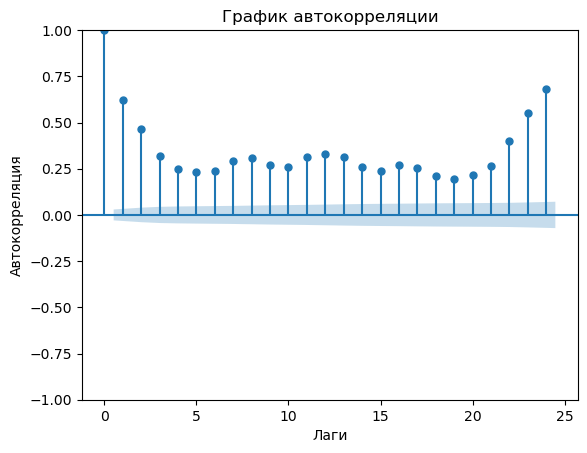

In [24]:
sm.graphics.tsa.plot_acf(features, lags=24)
plt.title('График автокорреляции')
plt.xlabel('Лаги')
plt.ylabel('Автокорреляция')
plt.show()

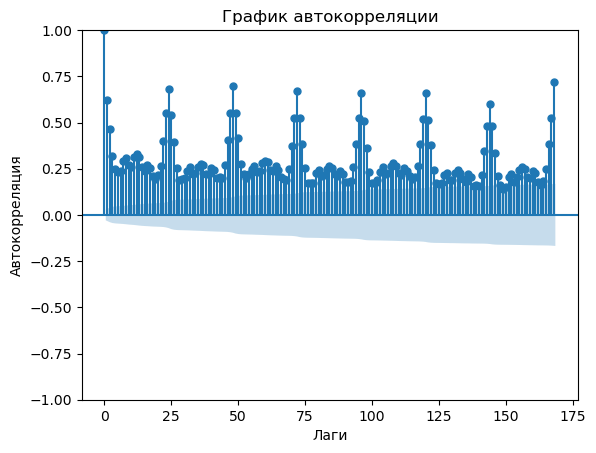

In [25]:
sm.graphics.tsa.plot_acf(features, lags=168)
plt.title('График автокорреляции')
plt.xlabel('Лаги')
plt.ylabel('Автокорреляция')
plt.show()

In [26]:
def make_features(DATA, max_lag, rolling_mean_size):
#     DATA['month'] = DATA.index.month
    DATA['day'] = DATA.index.day
    DATA['dayofweek'] = DATA.index.dayofweek
    DATA['hour'] = DATA.index.hour
    
    for lag in range(1, max_lag + 1):
        DATA['lag_{}'.format(lag)] = DATA['num_orders'].shift(lag)
    
    DATA['rolling_mean'] = DATA['num_orders'].shift().rolling(rolling_mean_size).mean()
    DATA.dropna(inplace=True)
    return DATA

In [27]:
features = make_features(features, 168, 12)
features

C:\Users\admin\AppData\Local\Temp\ipykernel_8260\4014206602.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  DATA['lag_{}'.format(lag)] = DATA['num_orders'].shift(lag)
C:\Users\admin\AppData\Local\Temp\ipykernel_8260\4014206602.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  DATA['lag_{}'.format(lag)] = DATA['num_orders'].shift(lag)
C:\Users\admin\AppData\Local\Temp\ipykernel_8260\4014206602.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which ha

num_orders  day  dayofweek  hour  lag_1  lag_2  lag_3  \
datetime                                                                     
2018-03-08 00:00:00         143    8          3     0   94.0  127.0  108.0   
2018-03-08 01:00:00          78    8          3     1  143.0   94.0  127.0   
2018-03-08 02:00:00          65    8          3     2   78.0  143.0   94.0   
2018-03-08 03:00:00          68    8          3     3   65.0   78.0  143.0   
2018-03-08 04:00:00          60    8          3     4   68.0   65.0   78.0   
...                         ...  ...        ...   ...    ...    ...    ...   
2018-08-31 19:00:00         136   31          4    19  207.0  217.0  197.0   
2018-08-31 20:00:00         154   31          4    20  136.0  207.0  217.0   
2018-08-31 21:00:00         159   31          4    21  154.0  136.0  207.0   
2018-08-31 22:00:00         223   31          4    22  159.0  154.0  136.0   
2018-08-31 23:00:00         205   31          4    23  223.0  159.0  154.0   

                     lag_4  lag_5  lag_6  ...  lag_160  lag_161  lag_162  \
datetime                                  ...                              
2018-03-08 00:00:00   76.0   50.0   99.0  ...     34.0     15.0     12.0   
2018-03-08 01:00:00  108.0   76.0   50.0  ...     69.0     34.0     15.0   
2018-03-08 02:00:00  127.0  108.0   76.0  ...     64.0     69.0     34.0   
2018-03-08 03:00:00   94.0  127.0  108.0  ...     96.0     64.0     69.0   
2018-03-08 04:00:00  143.0   94.0  127.0  ...     30.0     96.0     64.0   
...                    ...    ...    ...  ...      ...      ...      ...   
2018-08-31 19:00:00  116.0  133.0  166.0  ...    187.0    160.0    246.0   
2018-08-31 20:00:00  197.0  116.0  133.0  ...    196.0    187.0    160.0   
2018-08-31 21:00:00  217.0  197.0  116.0  ...    118.0    196.0    187.0   
2018-08-31 22:00:00  207.0  217.0  197.0  ...     74.0    118.0    196.0   
2018-08-31 23:00:00  136.0  207.0  217.0  ...     22.0     74.0    118.0   

                     lag_163  lag_164  lag_165  lag_166  lag_167  lag_168  \
datetime                                                                    
2018-03-08 00:00:00      6.0     43.0     66.0     71.0     85.0    124.0   
2018-03-08 01:00:00     12.0      6.0     43.0     66.0     71.0     85.0   
2018-03-08 02:00:00     15.0     12.0      6.0     43.0     66.0     71.0   
2018-03-08 03:00:00     34.0     15.0     12.0      6.0     43.0     66.0   
2018-03-08 04:00:00     69.0     34.0     15.0     12.0      6.0     43.0   
...                      ...      ...      ...      ...      ...      ...   
2018-08-31 19:00:00    273.0    173.0    242.0    166.0    179.0    113.0   
2018-08-31 20:00:00    246.0    273.0    173.0    242.0    166.0    179.0   
2018-08-31 21:00:00    160.0    246.0    273.0    173.0    242.0    166.0   
2018-08-31 22:00:00    187.0    160.0    246.0    273.0    173.0    242.0   
2018-08-31 23:00:00    196.0    187.0    160.0    246.0    273.0    173.0   

                     rolling_mean  
datetime                           
2018-03-08 00:00:00     69.250000  
2018-03-08 01:00:00     78.333333  
2018-03-08 02:00:00     80.250000  
2018-03-08 03:00:00     82.083333  
2018-03-08 04:00:00     83.500000  
...                           ...  
2018-08-31 19:00:00    163.416667  
2018-08-31 20:00:00    170.916667  
2018-08-31 21:00:00    168.583333  
2018-08-31 22:00:00    164.916667  
2018-08-31 23:00:00    167.583333  

[4248 rows x 173 columns]

In [28]:
# Код ревьюера
# from statsmodels.graphics import tsaplots

# taxi = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0]).resample('1H').sum()
# ts = taxi['num_orders']

# fig = tsaplots.plot_acf(ts,lags= 190)
# fig.set_size_inches(18.5, 6)
# plt.ylim(-.1, 1.1)
# plt.show() 

Создадим тренировочную и тестовую выборки

In [29]:
X = features.drop(['num_orders'], axis=1)
y = features['num_orders']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)

Были выбраны 2 модели для обучения => LinearRegression() и LightGBM()

### Линейная регрессия

In [30]:
train_models=[]

In [31]:
model_lr = LinearRegression()
param_grid = {'fit_intercept': [True, False], 'copy_X': [True, False], 'n_jobs': [1, -1]}

In [32]:
tscv = TimeSeriesSplit(n_splits=5)
gs= GridSearchCV(estimator=model_lr, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error')
gs.fit(X_train, y_train)

best_params_lr = gs.best_params_

# Создаем новую модель с лучшими гиперпараметрами
best_model_lr = LinearRegression(**best_params_lr)

start_fit_time = time.time()
# Обучаем модель на всем обучающем наборе данных
best_model_lr.fit(X_train, y_train)

fit_time_lr = time.time() - start_fit_time

In [33]:
start_predict_time = time.time()
predictions_lr = best_model_lr.predict(X_train)
predict_time_lr = time.time() - start_predict_time

In [34]:
# Оценка RMSE с кросс-валидацией
cv_rmse_lr = cross_val_score(best_model_lr, X_train, y_train, scoring='neg_mean_squared_error', cv=tscv)
rmse_lr = np.sqrt(-cv_rmse_lr)

print("Лучшие гиперпараметры модели LinearRegression: ", best_params_lr)
print("RMSE LinearRegression (кросс-валидация): %.2f" % rmse_lr.mean())

Лучшие гиперпараметры модели LinearRegression:  {'copy_X': True, 'fit_intercept': False, 'n_jobs': 1}
RMSE LinearRegression (кросс-валидация): 22.66


Значение метрики меньше 48

In [35]:
train_models.append([best_model_lr, rmse_lr])

### LightGBM

In [36]:
# Задаем параметры для поиска по сетке
param_grid = {'n_estimators': [100, 500, 1000], 'num_leaves': [n for n in range(20, 300, 20)]}

model = lgb.LGBMRegressor(random_state=12345)

gs = GridSearchCV(estimator=model,
                          param_grid=param_grid,
                          scoring='neg_root_mean_squared_error',
                          cv=tscv,
                          verbose=3)

# Обучаем с помощью кросс-валидации
gs.fit(X_train, y_train)

# Получаем лучшие гиперпараметры
best_params_lg = gs.best_params_

# Создаем новую модель с лучшими гиперпараметрами
best_model_lg = LGBMRegressor(**best_params_lg)

start_fit_time = time.time()
# Обучаем модель на всем обучающем наборе данных
best_model_lg.fit(X_train, y_train)
fit_time_lg = time.time() - start_fit_time

Fitting 5 folds for each of 42 candidates, totalling 210 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17112
[LightGBM] [Info] Number of data points in the train set: 638, number of used features: 172
[LightGBM] [Info] Start training from score 57.898119
[CV 1/5] END .n_estimators=100, num_leaves=20;, score=-19.786 total time=   0.1s
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21732
[LightGBM] [Info] Number of data points in the train set: 1275, number of used features: 172
[LightGBM] [Info] Start training from score 61.356863
[CV 2/5] END .n_estimators=100, num_leaves=20;, score=-21.060 total time=   0.1s
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.0

In [37]:
start_predict_time = time.time()
predictions_lg = best_model_lg.predict(X_train)
predict_time_lg = time.time() - start_predict_time

In [38]:
# Оценка RMSE с кросс-валидацией
cv_rmse_lg = cross_val_score(best_model_lg, X_train, y_train, scoring='neg_mean_squared_error', cv=tscv)
rmse_lg = np.sqrt(-cv_rmse_lg)

print("Лучшие гиперпараметры модели LGBMRegressor: ", best_params_lg)
print("RMSE LGBMRegressor (кросс-валидация): %.2f" % rmse_lg.mean())

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17112
[LightGBM] [Info] Number of data points in the train set: 638, number of used features: 172
[LightGBM] [Info] Start training from score 57.898119
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21732
[LightGBM] [Info] Number of data points in the train set: 1275, number of used features: 172
[LightGBM] [Info] Start training from score 61.356863
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001822 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24308
[LightGBM] [Info] Number of data points in the train set: 1912, number of used features: 172
[LightGBM] [Info] Start

Значение метрики меньше 48

In [39]:
train_models.append([best_model_lg, rmse_lg])

Итак модели обучены и получен следующий результат)

- Лучшие гиперпараметры модели LinearRegression:  {'copy_X': True, 'fit_intercept': False, 'n_jobs': 1}, RMSE: 22.66
- Лучшие гиперпараметры модели LGBMRegressor:  {'n_estimators': 100, 'num_leaves': 20}, RMSE: 23.09

## Тестирование

In [40]:
results = pd.DataFrame({'Model': ['Linear Regression', 'LightGBM'], 'Время обучения(с)': [fit_time_lr, fit_time_lg], 'Время предсказания (с)': [predict_time_lr, predict_time_lg], 'RMSE (кросс-валидация)': [rmse_lr.mean(), rmse_lg.mean()]})
display(results)

Model  Время обучения(с)  Время предсказания (с)  \
0  Linear Regression           0.023212                0.008892   
1           LightGBM           0.274580                0.020906   

   RMSE (кросс-валидация)  
0               22.657765  
1               23.093307

In [41]:
final = pd.DataFrame(train_models, columns=['model', 'rmse_train'])

In [42]:
# RMSE LightGBM на тестовой выборке
rmse_test = mean_squared_error(y_test, best_model_lg.predict(X_test), squared=False)
print("RMSE LGBMRegressor на тестовой выборке: %.2f" % rmse_test)

RMSE LGBMRegressor на тестовой выборке: 36.49


Значение метрики меньше 48

In [43]:
test_models = []

In [44]:
def display_result(target, pred, rmse):
    final = target.to_frame().reset_index()
    final['prediction'] = pd.Series(pred)
    final.set_index('datetime', inplace=True)
    
    time_series_graph(final, 'RMSE='+str(rmse))

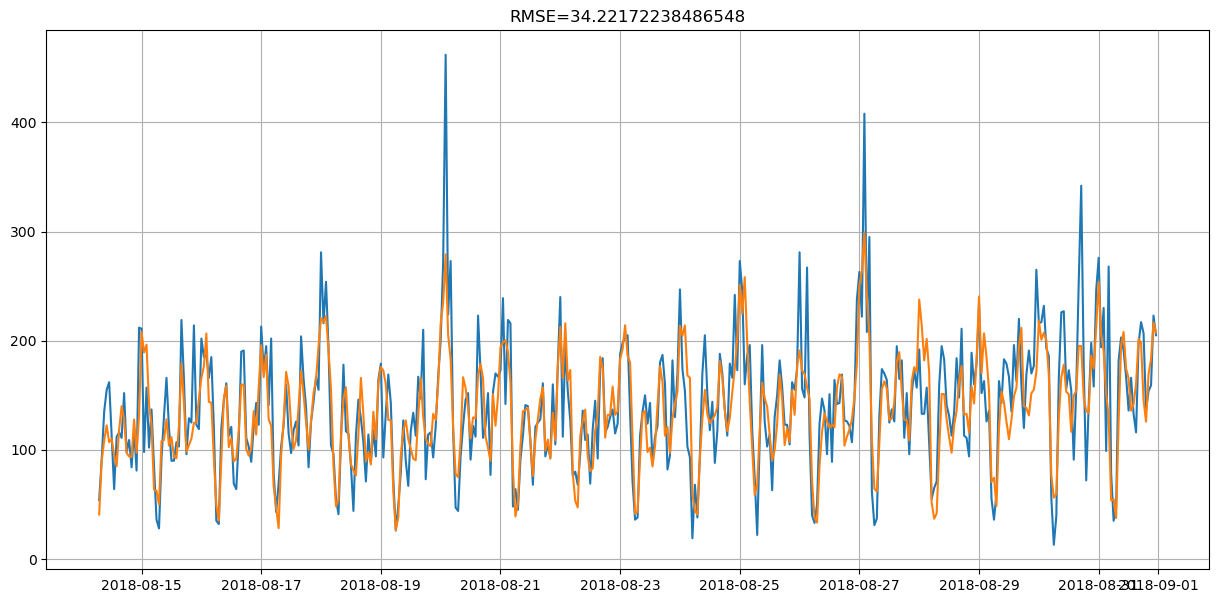

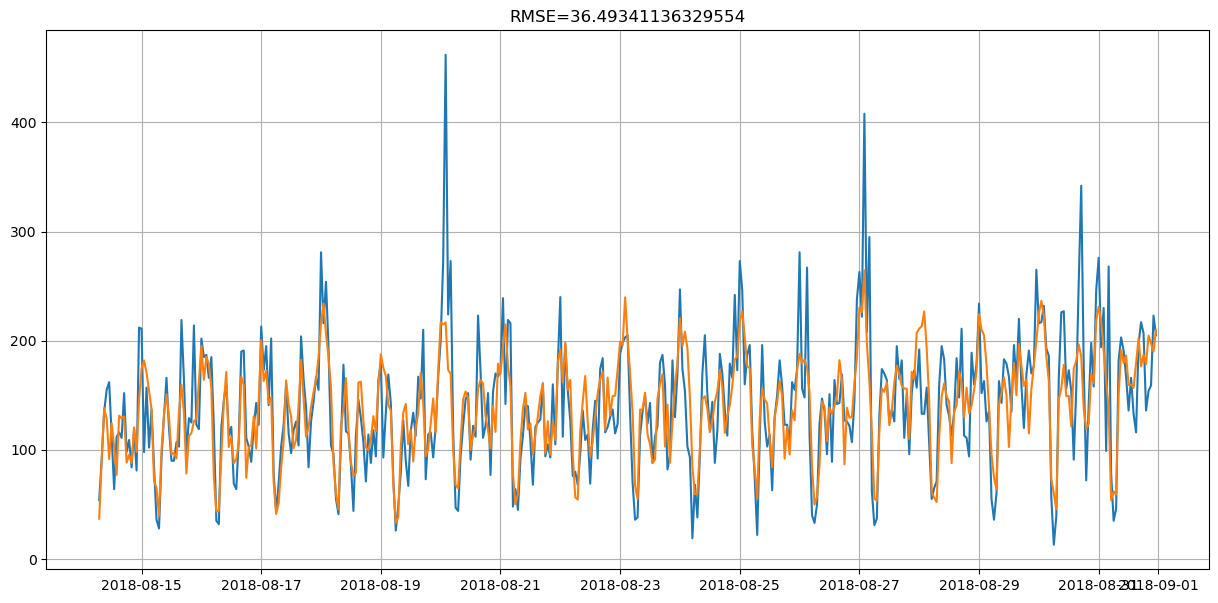

In [45]:
for i in range(len(train_models)):
    predictions = train_models[i][0].predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    display_result(y_test, predictions, rmse)
    test_models.append(rmse)

Видно, что LightGBM неплохо справляется на тествовой выборке, также данная модель довольно быстро обучается и делает предсказания, однако модель линейной регрессии имеет меньшее RMSE и лучше ведет себя на пиковых ситуациях, также ее время обучения и предсказания меньше, чем у LightGBM, поэтому модель LinearRegression: {'copy_X': True, 'fit_intercept': False, 'n_jobs': 1} можно смело рекомендовать заказчику.

## Общий вывод

Для решения поставленной задачи по разработке модели для прогнозирования количества заказов такси на следующий час была проделана работа:

1) Выгружены и подготовлены данные

2) Обучены модели LinReg и LGBMRegressor с подбором гиперпараметров

3) Проведено тестирование и выявлен фаворит исходя из запросов заказчика: LinearRegression: {'copy_X': True, 'fit_intercept': False, 'n_jobs': 1} - лучшая модель так как ее rmse и на тестовой выборке и на тренирововчной меньше 48 и меньше чем у LGBMRegressor), также эта модель довольно быстрая и ее время обучения и предсказания не превышает 1 секунды). Итак, данную модель совершенно точно можно рекомендовать без всяких опасений)

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48